# Chapter 2
One disadvantage of the neural network courses is they run from very old versions. So following along in a local notebook is a painful experience of errors, followed by downgrade detective work. This doesn't work with tensorflow 2.

Instead I create a new conda env called tensorflow v1 and python 3.6:
<pre>
conda create -n tensorflow
conda activate tensorflow
conda install py=3.6
conda install tensorflow=1
conda install jupyter ipykernel pandas keras matplotlib
</pre>

You then need to create a new kernel that uses this environment:
<pre>
conda activate tensorflow
python -m ipykernel install --user --name tensorflow --display-name tensorflow
</pre>

Then you can pick or change the kernel in Jupyter by reloading the page.

## Word Model
If I remove punctuation and new lines, and lower case text. How many words do I have? Run the model with this anyway, but if the results are poor, then tokenise but leave the stop words in. I need those for a sentence to make sense.

### Raw Lower Case Text Model

In [1]:
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

url = 'https://assets.datacamp.com/production/repositories/5286/datasets/2b130693c9bd45c528b60fa9efbf5148a3ff14e5/shakespear.txt'
file = 'shakespear.txt'

#urlretrieve(url, file)

text = ''
with open(file, 'r') as f:
    text = f.read()
    text = text.lower()

Using TensorFlow backend.


In [2]:
# Remove anything that isn't a space or lower case letter.
no_nl_text = re.sub('\n', ' ', text)
no_nl_text = re.sub('  ', ' ', no_nl_text)
no_nl_text = re.sub('\.', ' .', no_nl_text)
just_words = re.sub('[^a-z .]+', '', no_nl_text)

vocabulary = set(just_words.split())
len(vocabulary)

3508

That is a lot - the character set was 36 columns as OHE. Let's do some quick analysis of sentences.

In [3]:
# Assume a sentence ends in a dot
sentences = just_words.split('.')
len(sentences)

614

In [4]:
# split each sentence into words and count
sentence_length = [len(line.split()) for line in sentences]

# mean and median sentence length
sum(sentence_length)/len(sentence_length), sorted(sentence_length)[round(len(sentence_length)/2)]

(30.263843648208468, 22)

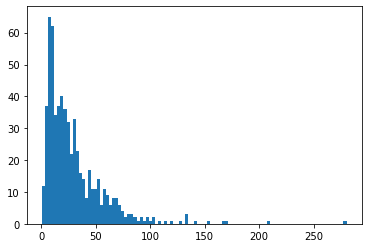

In [5]:
# What is the distribution of words per sentence
plt.hist(sentence_length, bins=100)
plt.show()

In [6]:
# Shakespear is an extreme case of sentence variation
# But let's start with the median as our max sequence length
# because our vocab is 120 times bigger
maxlen = 40

In [7]:
from collections import Counter

# remove the 20 most common words
text = just_words.split()
top_n = 100
stop_words = Counter(text).most_common()[:top_n]
stop_words = [word for word, count in stop_words]
text = [word for word in text if word not in stop_words]
vocabulary = set(text)
len(vocabulary)

3408

In [8]:
vocabulary = set(text)

# Dictionary to save the mapping from char to integer
word_to_idx = { word : idx for idx, word in enumerate(vocabulary) }

# Dictionary to save the mapping from integer to char
idx_to_word = { idx : word for idx, word in enumerate(vocabulary) }

# Create empty lists for input and target dataset
input_data = []
target_data = []

# Iterate to get all substrings of length maxlen
for i in range(0, len(text) - maxlen):
    # Find the sequence of length maxlen starting at i
    input_data.append(text[i : i+maxlen])
    
    # Find the next char after this sequence 
    target_data.append(text[i+maxlen])

# Print number of sequences in input data
print('No of Sequences:', len(input_data))

No of Sequences: 8422


In [9]:
input_data[1], target_data[1]

(['contempt',
  'claimd',
  'slept',
  'faithful',
  'contrive',
  'father',
  'defeated',
  'queen',
  'flesh',
  'broke',
  'puttance',
  'expedition',
  'house',
  'same',
  'ever',
  'lament',
  'stomach',
  'nor',
  'butly',
  'fury',
  'knowing',
  'everything',
  'grew',
  'daily',
  'ever',
  'great',
  'strength',
  'thought',
  'bright',
  'buds',
  'mine',
  'own',
  'biondello',
  'marry',
  'pray',
  'patience',
  'lear',
  'instant',
  'common',
  'maid'],
 'less')

In [10]:
# Create a 3-D zero vector to contain the encoded input sequences
x = np.zeros((len(input_data), maxlen, len(vocabulary)), dtype='float32')

# Create a 2-D zero vector to contain the encoded target characters
y = np.zeros((len(target_data), len(vocabulary)), dtype='float32')

In [11]:
# Iterate over the sequences
for s_idx, sequence in enumerate(input_data):
    # Iterate over all characters in the sequence
    for idx, word in enumerate(sequence):
        # Fill up vector x
        x[s_idx, idx, word_to_idx[word]] = 1    
    # Fill up vector y
    y[s_idx, word_to_idx[target_data[s_idx]]] = 1

In [12]:
# Create Sequential model 
model = Sequential()

# Add an LSTM layer of 128 units
model.add(LSTM(128, input_shape=(maxlen, len(vocabulary))))

# Add a Dense output layer
model.add(Dense(len(vocabulary), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model
model.fit(x, y, batch_size=64, epochs=1, validation_split=0.2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 6737 samples, validate on 1685 samples
Epoch 1/1
6737/6737 [==============================] - 15s 2ms/step - loss: 8.0276 - val_loss: 8.0024


In [13]:
import re

def clean_sent(sentence):
    text = sentence.lower()
    text = re.sub('[^a-z ]+','', text)
    return text.split()


def remove_stop(words):
    return [word for word in words if word not in stop_words]


def repeat(sentence):
    words = sentence.split()
    res = False
    if len(set(words[-10:])) < 9:
        res = True
    elif len(set(words[-2:])) == 1:
        res = True
    elif len(set(words[-5:])) < 4:
        res = True
    return res


def random(preds):
    top_n = round(len(vocabulary)**0.5)
    top_preds = preds.argsort()[- top_n-5:-5]
    idx = np.random.choice(top_preds)
    return idx


def generate_text(sentence, no_words):
    maxlen = 40
    text = clean_sent(sentence)
    text = remove_stop(text)
    for i in range(no_words):
        text = text[i:maxlen+i]
        X_test = np.zeros((1, maxlen, len(vocabulary)))
        for s_idx, word in enumerate(text):
            X_test[0, s_idx, word_to_idx[word]] = 1
        preds_next_word = model.predict(X_test)[0]
        if repeat(sentence):
            idx = random(preds_next_word)
        else:
            idx = np.argmax(preds_next_word)
        next_word = idx_to_word[idx]
        sentence += ' ' + next_word
    return(sentence)

In [14]:
# Input sequence and generate text
sentence = "that, poor contempt, or claim'd thou sleep"
print(generate_text(sentence, 30))

that, poor contempt, or claim'd thou sleep cause can every every john every tis great any master been john before wife every every doth every john hand master very who tis without every every could every doth


In [15]:
# pick random maxlen snippets
for _ in range(5):
    max_words = len(text)
    idx = round(np.random.uniform()*(max_words-maxlen))
    sentence = ' '.join(text[idx:idx+maxlen])
    new = generate_text(sentence, 10)
    print(sentence + '\n' + new + '\n')

eye other ground likey queen elizabeth each choked whiles nature between fanny little fault lightly read thus wellmet whiles been son blind damned bonds citizen removed cannot speak host loath amazedgo parted hands marshally vile haste noble hand used naked
eye other ground likey queen elizabeth each choked whiles nature between fanny little fault lightly read thus wellmet whiles been son blind damned bonds citizen removed cannot speak host loath amazedgo parted hands marshally vile haste noble hand used naked every every very every bloody even heart husband doth could

tremble has privilege creatures citizens plain cur measure goodness gods romery doe breastbold flatterers esemble sun condemnd myill oclock sensual being deep easy welled search gloss leaven vincentio followo issue friends up lady silent offences clother appear prince henry pray
tremble has privilege creatures citizens plain cur measure goodness gods romery doe breastbold flatterers esemble sun condemnd myill oclock sen

In [20]:
# Build a class
# get data
# clean data
# vectorize data
# run model
# generate text
# score generated text?